In [18]:
import json
import matplotlib.pyplot as plt

In [2]:
with open("final-data/process.log") as f:
    process_log = f.readlines()

In [5]:
process_log = list(map(json.loads, process_log))

In [9]:
targets = [f"frost-{i:02d}" for i in range(5)]
targets.append("relayer")
targets

['frost-00', 'frost-01', 'frost-02', 'frost-03', 'frost-04', 'relayer']

In [10]:
def find_tag(p, tl):
    for t in tl:
        if t in " ".join(p["cmd"]):
            return t
    return ""

In [7]:
set(map(lambda x: x["name"], process_log))

{'frostd', 'ignite'}

In [14]:
procs = {}
for l in process_log:
    t = find_tag(l, targets)
    if t == '':
        continue
    if t not in procs:
        procs[t] = []
    procs[t].append(l)

In [151]:
import numpy as np

def catch_plot(main_array, data_selector_fn, smooth=200, label=None):
    times = []
    data = []

    for l in main_array:
        times.append(l["now"])
        data.append(data_selector_fn(l))
    
    mt = min(times)
    times = list(map(lambda x: (x - mt)/1e9, times))

    smoothed = np.convolve(data, np.ones(200)/200)

    if smooth == 0:
        crop = 0
    else:
        crop = -1 * smooth + 1
    
    plt.plot(times, smoothed[:crop], label=label)

In [70]:
l

{'now': 1702109412739681318,
 'name': 'ignite',
 'cmd': ['ignite', 'relayer', 'connect'],
 'cpu-%': 220.9,
 'cpu-times': {'user': 1620.8,
  'system': 299.75,
  'children_user': 1688.21,
  'children_system': 134.69,
  'iowait': 0.0},
 'io-counters': {'read_count': 1282169,
  'write_count': 63240,
  'read_bytes': 0,
  'write_bytes': 198668861440,
  'read_chars': 8507770066,
  'write_chars': 198682143519},
 'mem-full': {'rss': 534528000,
  'vms': 6622437376,
  'shared': 84647936,
  'text': 25051136,
  'lib': 0,
  'data': 674021376,
  'dirty': 0,
  'uss': 493309952,
  'pss': 500375552,
  'swap': 0},
 'mem-%': 1.6267455415953227}

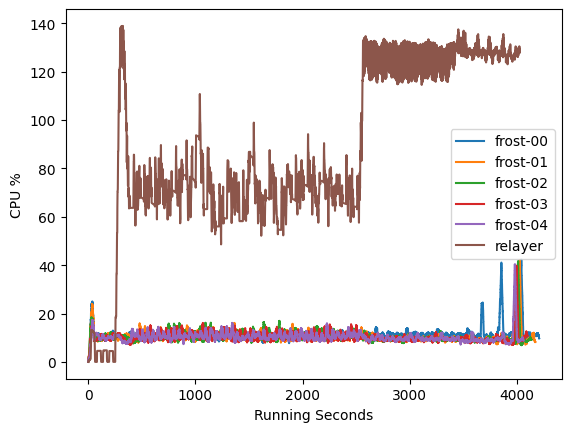

In [154]:
catch_plot(procs["frost-00"], lambda l: l["cpu-%"], label="frost-00")
catch_plot(procs["frost-01"], lambda l: l["cpu-%"], label="frost-01")
catch_plot(procs["frost-02"], lambda l: l["cpu-%"], label="frost-02")
catch_plot(procs["frost-03"], lambda l: l["cpu-%"], label="frost-03")
catch_plot(procs["frost-04"], lambda l: l["cpu-%"], label="frost-04")
catch_plot(procs["relayer"], lambda l: l["cpu-%"], label="relayer")
plt.xlabel('Running Seconds')  
plt.ylabel('CPU %')  
plt.legend()
plt.savefig('cpu.pdf')  

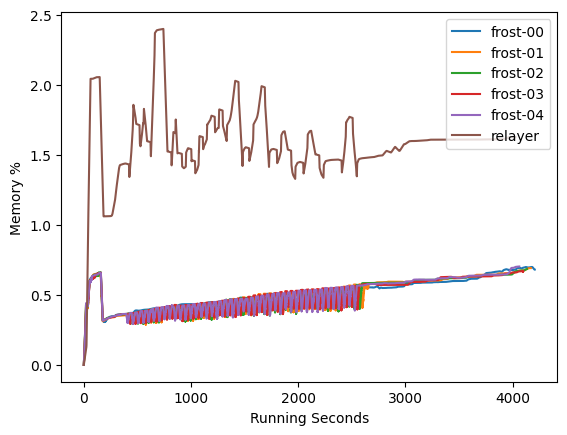

In [159]:
catch_plot(procs["frost-00"], lambda l: l["mem-%"], label="frost-00")
catch_plot(procs["frost-01"], lambda l: l["mem-%"], label="frost-01")
catch_plot(procs["frost-02"], lambda l: l["mem-%"], label="frost-02")
catch_plot(procs["frost-03"], lambda l: l["mem-%"], label="frost-03")
catch_plot(procs["frost-04"], lambda l: l["mem-%"], label="frost-04")
catch_plot(procs["relayer"], lambda l: l["mem-%"], label="relayer")
plt.xlabel('Running Seconds')  
plt.ylabel('Memory %')  
plt.legend(loc="upper right")
plt.savefig('mem.pdf')  

In [52]:
cpu_data_times = []
cpu_data = []

for l in procs["relayer"]:
    cpu_data_times.append(l["now"])
    cpu_data.append(l["cpu-%"])

In [54]:
mt = min(cpu_data_times)
times = list(map(lambda x: (x - mt)/1e9, cpu_data_times))

In [55]:
import numpy as np
smoothed = np.convolve(cpu_data, np.ones(200)/200)

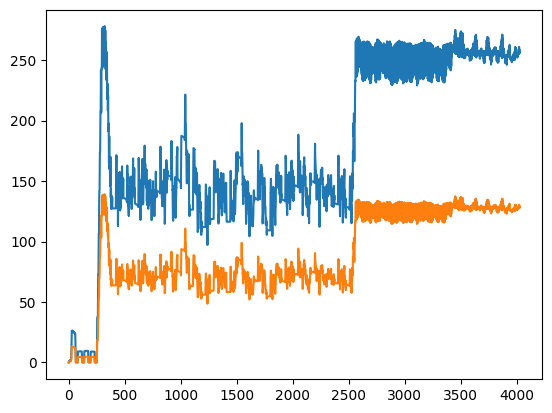

In [120]:
# plt.plot(times, smoothed[:-199] * 2)
plt.plot(times, smoothed[:-199])

In [79]:
time_relayer_start_establish = 1702105409513
time_relayer_done_establish = 1702105638822

In [175]:
time_relayer_done_establish - time_relayer_start_establish

229309

In [101]:
from datetime import datetime, timezone

def parse_date(d, utc=True):
    timestamp_str = d[:-4] + "Z"
    timestamp = datetime.strptime(timestamp_str, '%Y-%m-%dT%H:%M:%S.%fZ')
    if utc:
        timestamp = timestamp.replace(tzinfo=timezone.utc)
    unix_milliseconds = int(timestamp.timestamp() * 1000)
    return unix_milliseconds

In [168]:
def read_blocks(chain_id):
    with open(f"final-data/blocks-{chain_id}.json") as f:
        blocks = json.load(f)
    bd = []
    for b in blocks:
        bd.append((parse_date(b["block"]["header"]["time"]), len(b["txs"])))
    return bd

In [162]:
def tps(blockL):
    last = None
    tps = []
    for l in blockL:
        if last is None:
            last = l
            continue
        mt, mc = l
        lt, lc = last
        tps.append(mc / (mt - lt))
    return tps

In [165]:
def smth(a, f=200):
    return np.convolve(a, np.ones(f)/f)

In [169]:
def plot_tps(chain_id):
    b = read_blocks(chain_id)
    t = tps(b)
    plt.plot(smth(t, f=50), label=f"{chain_id:02d}")

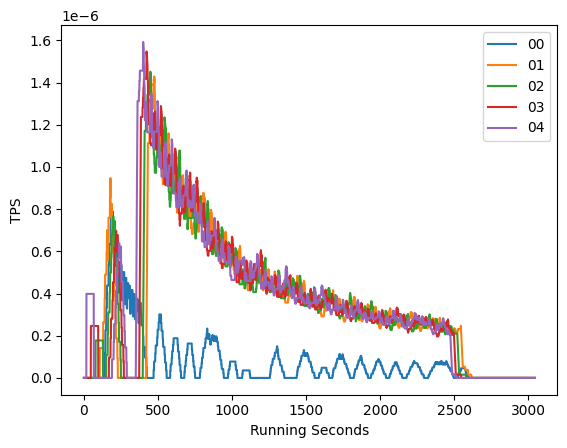

In [172]:
plot_tps(0)
plot_tps(1)
plot_tps(2)
plot_tps(3)
plot_tps(4)
plt.legend()
plt.xlabel('Running Seconds')  
plt.ylabel('TPS')  
plt.savefig('tps.pdf')  

In [128]:
all_relayer_logs = []
for i in range(1, 21):
    with open(f"final-data/logs/relayer{i}.log") as f:
        all_relayer_logs.extend(f.readlines())

In [130]:
rl = list(filter(lambda x: ": Relay" in x, all_relayer_logs))

In [136]:
rld = {"pack": [], "ack": []}
for r in rl:
    t, ee = r.split(":")
    t = int(t.strip())
    dx: str = ee.strip().replace("Relay ", "")
    i = dx.index(" ")
    count = int(dx[:i])
    ty = ""
    if "packet" in r:
        ty = "pack"
    else:
        ty = "ack"
    rld[ty].append((t, count))

In [138]:
rd_times = [a[0] for a in rld["pack"]]
rd_packs = np.cumsum([a[1] for a in rld["pack"]])

In [139]:
with open("final-data/ibc-send.log") as f:
    ibc_p = f.readlines()
    ibc_p = list(map(lambda x: int(x.split(" ")[-1]), ibc_p))

In [141]:
ibc_times = ibc_p
ibc_packs = np.cumsum([1 for _ in ibc_times])

In [146]:
m_t = min(min(ibc_times), min(rd_times))
a_t = lambda a, m: list(map(lambda _i: _i - m, a)) 

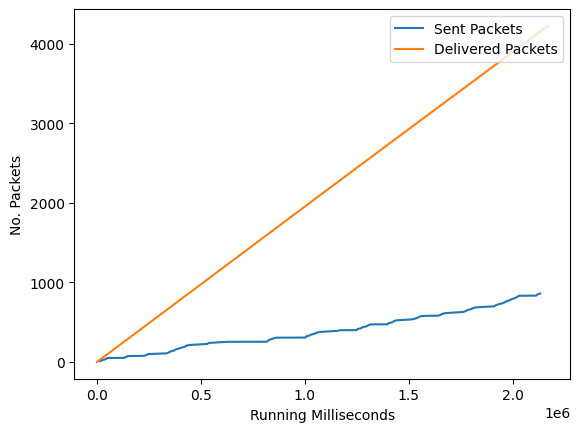

In [174]:
plt.plot(a_t(rd_times, m_t), rd_packs, label="Sent Packets")
plt.plot(a_t(ibc_times, m_t), ibc_packs, label="Delivered Packets")
plt.xlabel('Running Milliseconds')  
plt.ylabel('No. Packets')  
plt.legend(loc="upper right")
plt.savefig('packs.pdf')  